## FORECASTING EXCHANGE RATES USING TIME SERIES ANALYSIS

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')

#from keras.layers.core import Dense, Activation, Dropout
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM

### Data Preparation and Exploration

**Data Loading**

In [122]:
df = pd.read_csv('exchange_rate.csv')
df.head()

,date,Ex_rate
0,01-01-1990 00:00,0.7855
1,02-01-1990 00:00,0.7818
2,03-01-1990 00:00,0.7867
3,04-01-1990 00:00,0.7860
4,05-01-1990 00:00,0.7849


In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     7588 non-null   object 
 1   Ex_rate  7588 non-null   float64
dtypes: float64(1), object(1)
memory usage: 118.7+ KB


**Ensuring if the Date Parsing is Correct:**

In [124]:
# Convert the date column to datetime
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y %H:%M')

# Print DataFrame info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     7588 non-null   datetime64[ns]
 1   Ex_rate  7588 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 118.7 KB


In [125]:
df.head()

,date,Ex_rate
0,1990-01-01,0.7855
1,1990-01-02,0.7818
2,1990-01-03,0.7867
3,1990-01-04,0.7860
4,1990-01-05,0.7849


In [126]:
df['year'] = df['date'].dt.year
df.head()

,date,Ex_rate,year
0,1990-01-01,0.7855,1990
1,1990-01-02,0.7818,1990
2,1990-01-03,0.7867,1990
3,1990-01-04,0.7860,1990
4,1990-01-05,0.7849,1990


**Initial Exploration:**

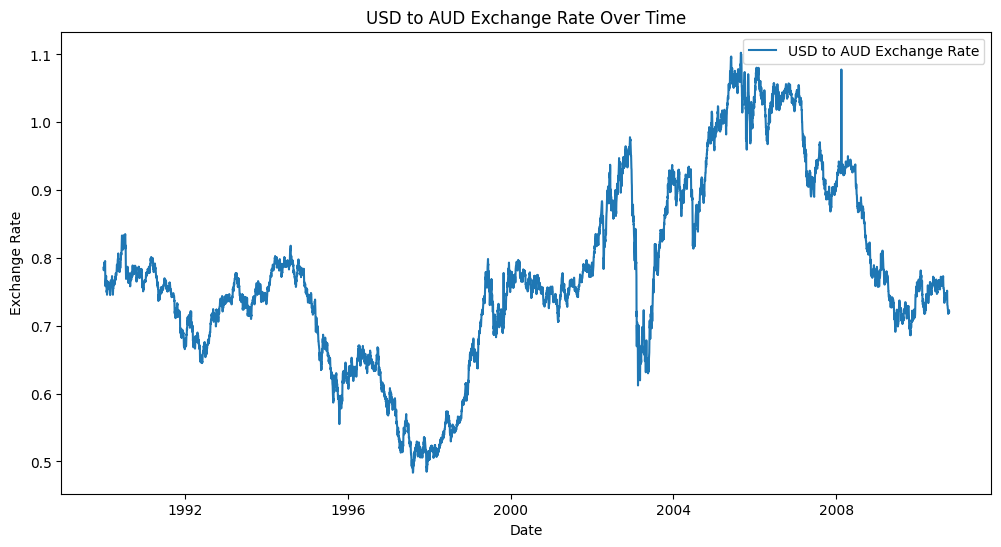

In [127]:
# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['Ex_rate'], label='USD to AUD Exchange Rate')
plt.title('USD to AUD Exchange Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

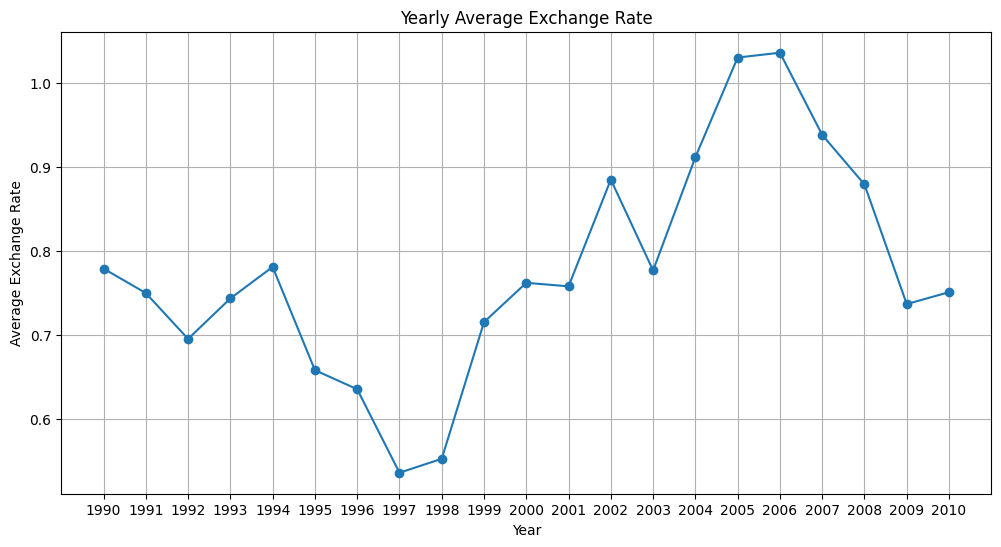

In [128]:
# Checking the overal trend
# Aggregate data by year
yearly_data = df.groupby('year')['Ex_rate'].mean().reset_index()

# Plotting the line graph for yearly data
plt.figure(figsize=(12, 6))
plt.plot(yearly_data['year'], yearly_data['Ex_rate'], marker='o')
plt.title('Yearly Average Exchange Rate')
plt.xlabel('Year')
plt.ylabel('Average Exchange Rate')
plt.grid(True)
plt.xticks(yearly_data['year'])
plt.show()

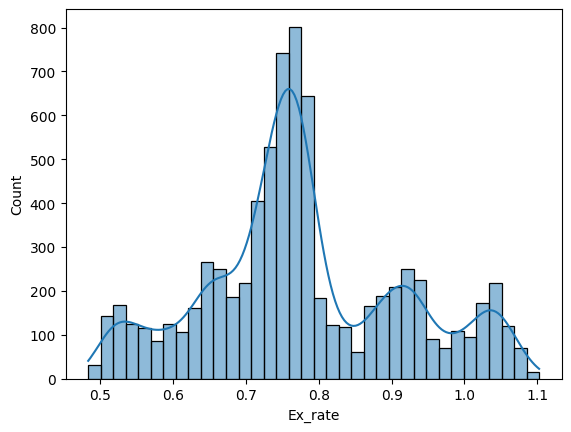

In [129]:
# Histogram and density plots
sns.histplot(df['Ex_rate'], kde=True)
plt.show()

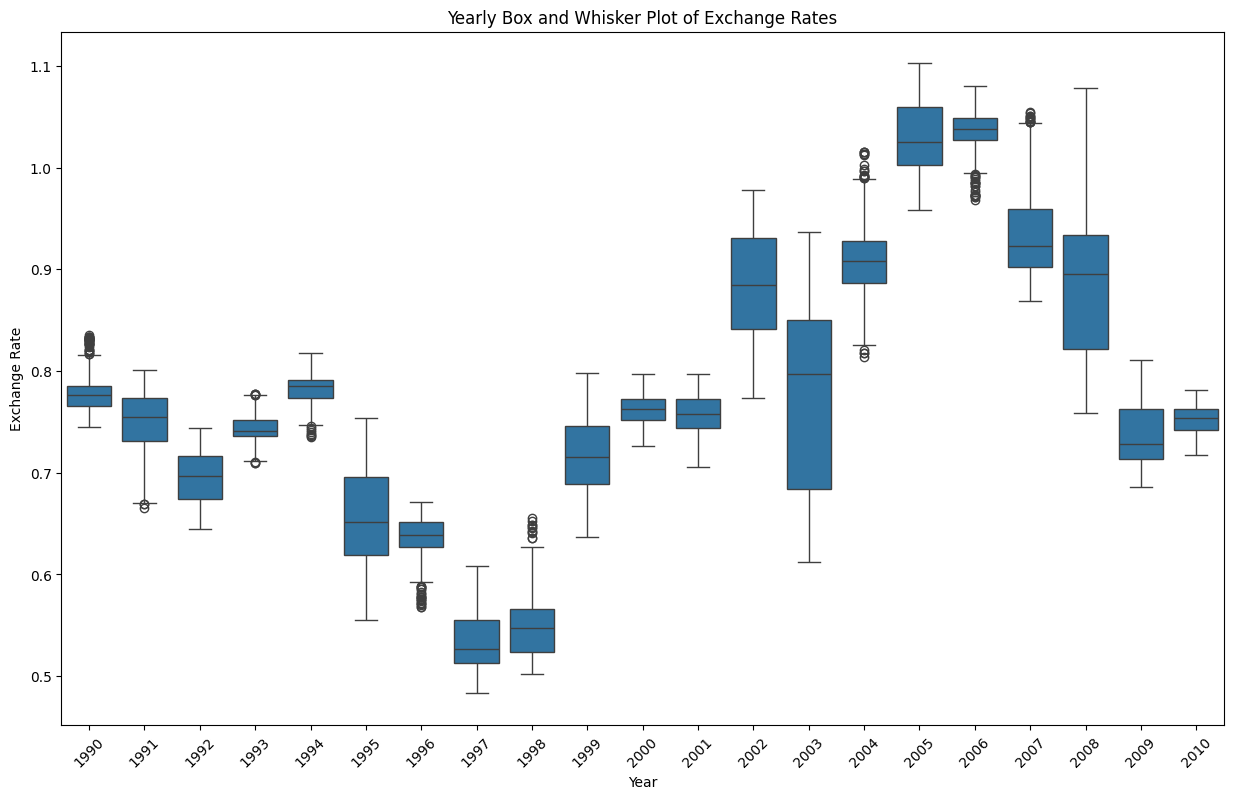

In [130]:
# Plotting the box plot with the original daily data grouped by year
plt.figure(figsize=(15, 9))
sns.boxplot(x='year', y='Ex_rate', data=df)
plt.title('Yearly Box and Whisker Plot of Exchange Rates')
plt.xlabel('Year')
plt.ylabel('Exchange Rate')
plt.xticks(rotation=45)
plt.show()

In [131]:
# Set the date column as the index
df.set_index('date', inplace=True)

In [132]:
df.drop('year', axis=1, inplace=True)
df.head()

,Ex_rate
date,
1990-01-01,0.7855
1990-01-02,0.7818
1990-01-03,0.7867
1990-01-04,0.7860
1990-01-05,0.7849


**Data Preprocessing**

### Model Building - ARIMA

**Parameter Selection for ARIMA:**

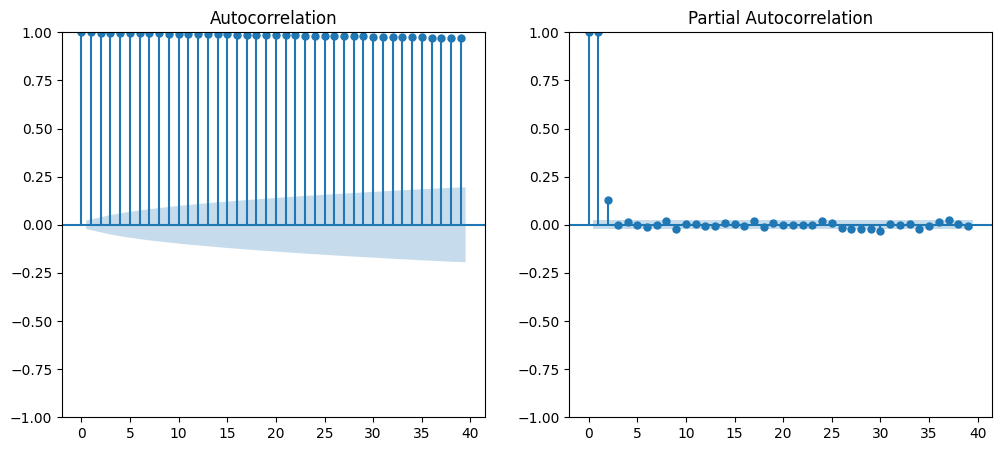

In [62]:
# Plot ACF and PACF
plt.figure(figsize=(12, 5))
plt.subplot(121)
plot_acf(df['Ex_rate'], ax=plt.gca())
plt.subplot(122)
plot_pacf(df['Ex_rate'], ax=plt.gca())
plt.show()

Since the above plots shows that multiple lagged versions cross the boundary showing strong correlation, I am using grid search for choosing best parameters for ARIMA.

In [63]:
# Split data into training and testing
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]
train.shape, test.shape

((6070, 1), (1518, 1))

### Grid Search for Hyperparameters

In [64]:
import itertools

# Define p, d, q parameters to test
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

best_rmse = np.inf
best_pdq = None

# Grid search for best parameters based on RMSE
for param in pdq:
    try:
        model = ARIMA(train, order=param)
        results = model.fit()

        # Forecast the training data
        forecast_train = results.predict(start=train.index[0], end=train.index[-1])

        # Compute RMSE for training data
        rmse_train = np.sqrt(mean_squared_error(train, forecast_train))

        if rmse_train < best_rmse:
            best_rmse = rmse_train
            best_pdq = param
    except Exception as e:
        print(f"Error for parameters {param}: {e}")
        continue

print(f'Best ARIMA parameters: {best_pdq}')
print(f'Best Training RMSE: {best_rmse}')

Best ARIMA parameters: (2, 0, 2)
Best Training RMSE: 0.005737088981483802


In [65]:
# Fit the model with the best parameters
best_model = ARIMA(train, order=best_pdq)
best_results = best_model.fit()

# Forecast the values
forecast_ARIMA = best_results.forecast(steps=len(test))

In [66]:
# Compute Test RMSE
rmse = np.sqrt(mean_squared_error(test, forecast_ARIMA))
print(f'RMSE: {rmse}')

RMSE: 0.11933685107358687


In [67]:
# Calculate MAE
mae_test_ARIMA = mean_absolute_error(test['Ex_rate'], forecast_ARIMA)

# Calculate MAPE
mape_test_ARIMA = np.mean(np.abs((test['Ex_rate'] - forecast_ARIMA) / test['Ex_rate'])) * 100

In [68]:
# Output results
print(f'MAE (Test): {mae_test_ARIMA}')
print(f'MAPE (Test): {mape_test_ARIMA}')

MAE (Test): 0.10143364750950568
MAPE (Test): 13.035811240015653


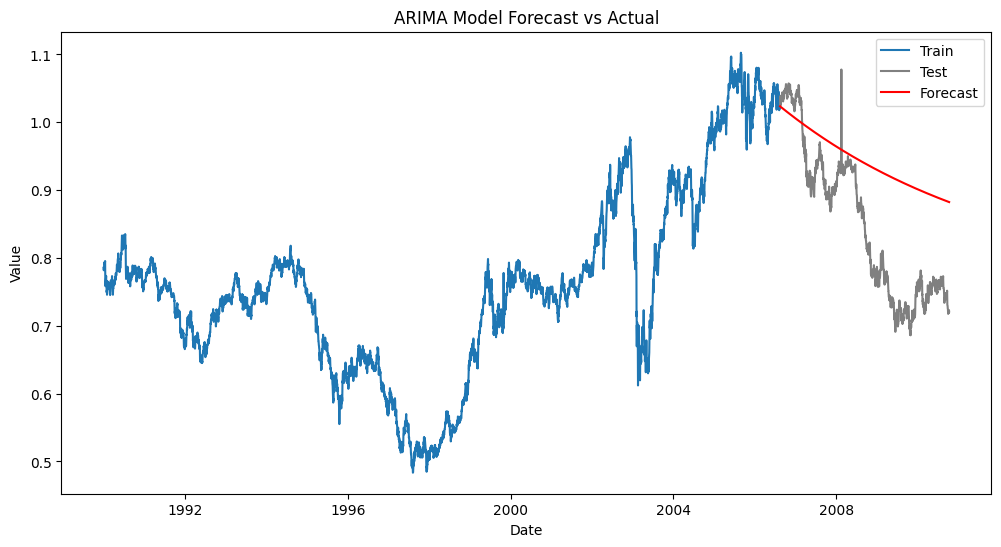

In [69]:
# Plot actual vs forecasted values
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='gray')
plt.plot(test.index, forecast_ARIMA, label='Forecast', color='red')
plt.legend()
plt.title('ARIMA Model Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

In [70]:
# Check residuals
residuals = best_results.resid

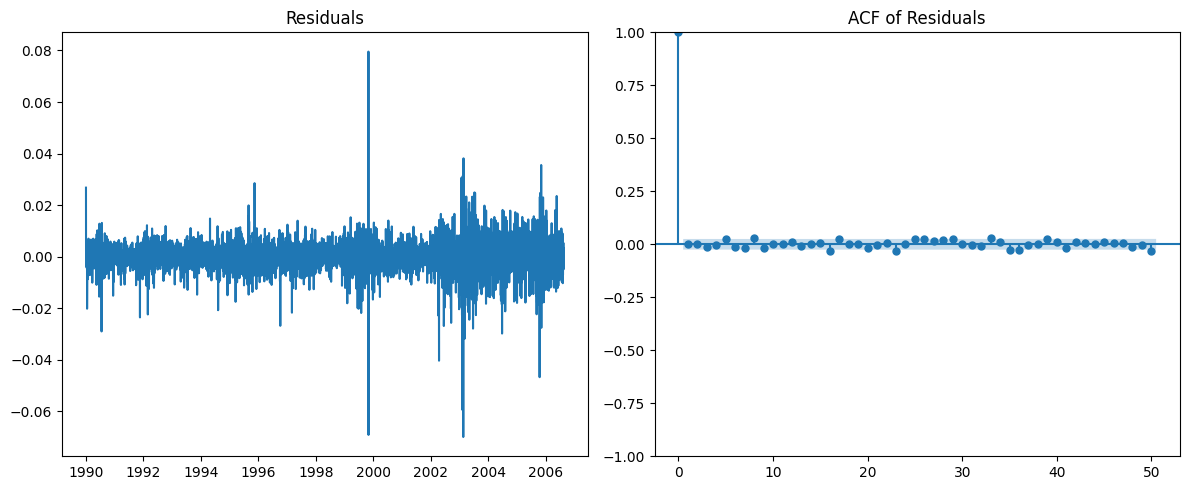

In [71]:
# Plot residuals and their ACF
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(residuals)
plt.title('Residuals')

plt.subplot(1, 2, 2)
plot_acf(residuals, ax=plt.gca(), lags=50)
plt.title('ACF of Residuals')

plt.tight_layout()
plt.show()

There is no such pattern in the residual plot.

### Exponential Smoothing

#### Using RMSE as metric

In [72]:
# Define a function to perform grid search over Holt-Winters model parameters
def grid_search_exponential_smoothing(train, test, seasonal_periods_list):
    best_rmse_test = np.inf
    best_params = None
    best_model = None
    best_rmse_train = None

    # Loop over possible seasonal periods
    for seasonal_periods in seasonal_periods_list:
        # Loop over possible parameters
        for trend in ['add', 'mul', None]:
            for seasonal in ['add', 'mul', None]:
                for damped in [True, False]:
                    try:
                        # Fit the model on the training data
                        model = ExponentialSmoothing(
                            train['Ex_rate'],
                            trend=trend,
                            seasonal=seasonal,
                            seasonal_periods=seasonal_periods,
                            damped_trend=damped,
                        ).fit()

                        # Forecast on validation data
                        forecast_test = model.forecast(steps=len(test))
                        forecast_train = model.fittedvalues  # Fitted values for training data

                        # Calculate RMSE for train and test data
                        rmse_train = np.sqrt(mean_squared_error(train['Ex_rate'], forecast_train))
                        rmse_test = np.sqrt(mean_squared_error(test['Ex_rate'], forecast_test))

                        # Find the best model based on the test RMSE
                        if rmse_test < best_rmse_test:
                            best_rmse_test = rmse_test
                            best_rmse_train = rmse_train
                            best_params = (trend, seasonal, damped, seasonal_periods)
                            best_model = model
                    except:
                        continue

    return best_model, best_params, best_rmse_train, best_rmse_test

In [73]:
# Define a list of seasonal periods to try
seasonal_periods_list = [30, 60, 180, 365]

In [74]:
# Perform grid search on training data with multiple seasonal periods
best_model, best_params, best_rmse_train, best_rmse_test = grid_search_exponential_smoothing(train, test, seasonal_periods_list)

In [75]:
# Output results
print(f'Best Model Parameters: Trend={best_params[0]}, Seasonal={best_params[1]}, Damped={best_params[2]}, Seasonal Periods={best_params[3]}')
print(f'Best RMSE (Train): {best_rmse_train}')
print(f'Best RMSE (Test): {best_rmse_test}')

Best Model Parameters: Trend=mul, Seasonal=add, Damped=True, Seasonal Periods=180
Best RMSE (Train): 0.005832515377999787
Best RMSE (Test): 0.14036133005231322


In [76]:
# Forecast on training and test data using the best model
forecast_test = best_model.forecast(steps=len(test))

In [77]:
# Calculate MAE
mae_test = mean_absolute_error(test['Ex_rate'], forecast_test)

# Calculate MAPE
mape_test = np.mean(np.abs((test['Ex_rate'] - forecast_test) / test['Ex_rate'])) * 100

In [78]:
# Output results
print(f'MAE (Test): {mae_test}')
print(f'MAPE (Test): {mape_test}')

MAE (Test): 0.11427279763051523
MAPE (Test): 14.798123145943451


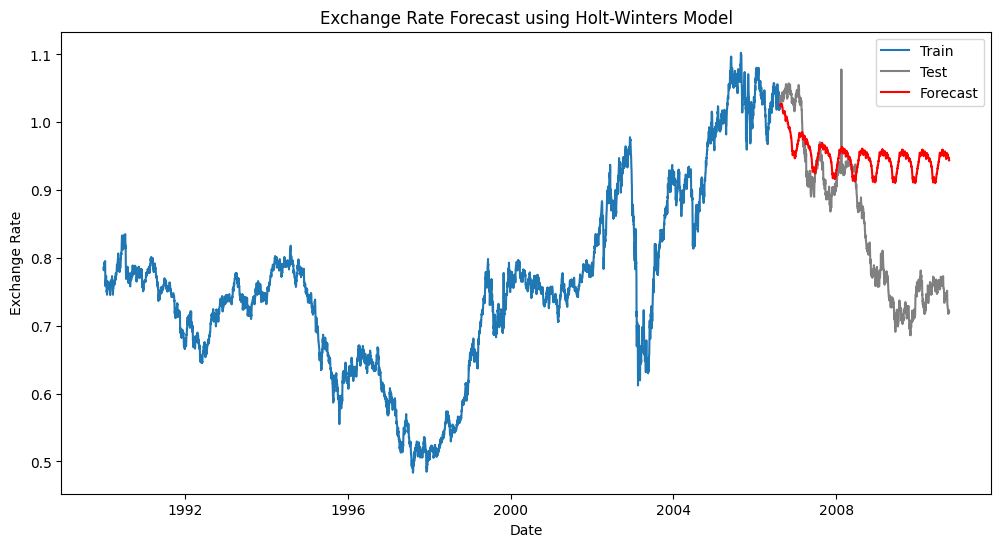

In [79]:
# Plot the forecast against the actual data
forecast = best_model.forecast(steps=len(test))
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='gray')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.legend()
plt.title('Exchange Rate Forecast using Holt-Winters Model')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.show()

#### Using AIC as metric

In [80]:
# Define a function to perform grid search over Holt-Winters model parameters using AIC as metric
def grid_search_exponential_smoothing_aic(train, test, seasonal_periods_list):
    best_aic = np.inf
    best_params = None
    best_model = None

    # Loop over possible seasonal periods
    for seasonal_periods in seasonal_periods_list:
        # Loop over possible parameters
        for trend in ['add', 'mul', None]:
            for seasonal in ['add', 'mul', None]:
                for damped in [True, False]:
                    try:
                        # Fit the model on the training data
                        model = ExponentialSmoothing(
                            train['Ex_rate'],
                            trend=trend,
                            seasonal=seasonal,
                            seasonal_periods=seasonal_periods,
                            damped_trend=damped,
                        ).fit()

                        # Calculate AIC for the model
                        aic = model.aic

                        # Find the best model based on AIC
                        if aic < best_aic:
                            best_aic = aic
                            best_params = (trend, seasonal, damped, seasonal_periods)
                            best_model = model
                    except:
                        continue

    return best_model, best_params, best_aic

In [81]:
# Define a list of seasonal periods to try
seasonal_periods_list = [30, 60, 180, 365]

In [82]:
# Perform grid search on training data with multiple seasonal periods using AIC as metric
best_model, best_params, best_aic = grid_search_exponential_smoothing_aic(train, test, seasonal_periods_list)

In [83]:
# Output results
print(f'Best Model Parameters: Trend={best_params[0]}, Seasonal={best_params[1]}, Damped={best_params[2]}, Seasonal Periods={best_params[3]}')
print(f'Best AIC: {best_aic}')

Best Model Parameters: Trend=None, Seasonal=None, Damped=False, Seasonal Periods=30
Best AIC: -62659.336804587016


In [84]:
# Forecast on training and test data using the best model
forecast_test_1 = best_model.forecast(steps=len(test))

In [85]:
# Calculate MAE
mae_test_1 = mean_absolute_error(test['Ex_rate'], forecast_test_1)

# Calculate MAPE
mape_test_1 = np.mean(np.abs((test['Ex_rate'] - forecast_test_1) / test['Ex_rate'])) * 100

# Output results
print(f'MAE (Test): {mae_test_1}')
print(f'MAPE (Test): {mape_test_1}')

MAE (Test): 0.1776379447660641
MAPE (Test): 22.788834587398952


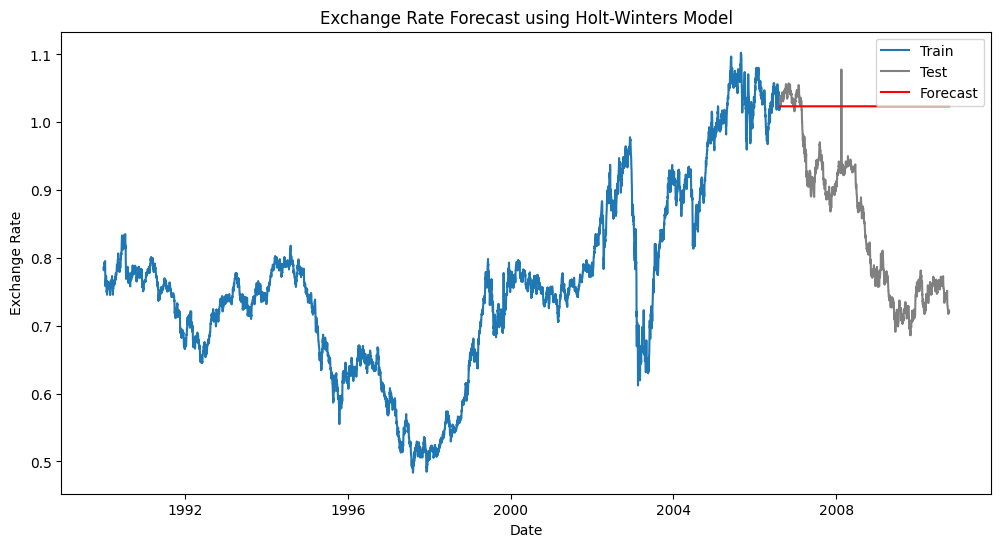

In [86]:
# Plot the forecast against the actual data
forecast_aic = best_model.forecast(steps=len(test))

plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='gray')
plt.plot(test.index, forecast_aic, label='Forecast', color='red')
plt.legend()
plt.title('Exchange Rate Forecast using Holt-Winters Model')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.show()

### Forecasting with LSTM

Epoch 1/20
90/90 - 16s - 176ms/step - loss: 0.0109
Epoch 2/20
90/90 - 20s - 227ms/step - loss: 3.4985e-04
Epoch 3/20
90/90 - 21s - 228ms/step - loss: 3.2644e-04
Epoch 4/20
90/90 - 14s - 158ms/step - loss: 3.0803e-04
Epoch 5/20
90/90 - 20s - 227ms/step - loss: 2.9543e-04
Epoch 6/20
90/90 - 14s - 157ms/step - loss: 2.8732e-04
Epoch 7/20
90/90 - 14s - 159ms/step - loss: 2.7449e-04
Epoch 8/20
90/90 - 20s - 226ms/step - loss: 2.6613e-04
Epoch 9/20
90/90 - 21s - 228ms/step - loss: 2.5649e-04
Epoch 10/20
90/90 - 20s - 225ms/step - loss: 2.4869e-04
Epoch 11/20
90/90 - 14s - 157ms/step - loss: 2.4208e-04
Epoch 12/20
90/90 - 21s - 228ms/step - loss: 2.4002e-04
Epoch 13/20
90/90 - 14s - 157ms/step - loss: 2.2612e-04
Epoch 14/20
90/90 - 14s - 158ms/step - loss: 2.2732e-04
Epoch 15/20
90/90 - 20s - 226ms/step - loss: 2.2264e-04
Epoch 16/20
90/90 - 21s - 228ms/step - loss: 2.0694e-04
Epoch 17/20
90/90 - 21s - 228ms/step - loss: 2.0544e-04
Epoch 18/20
90/90 - 20s - 225ms/step - loss: 1.9740e-04
Epoch

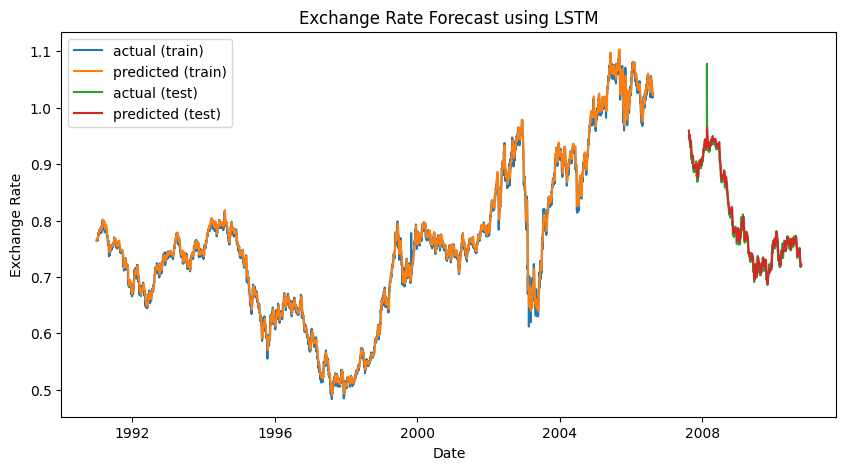

In [133]:
# normalize data
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

# split data into train and test sets
train_size = int(len(df_scaled) * 0.8)
train, test = df_scaled[:train_size], df_scaled[train_size:]

# create time series data for LSTM
def create_timeseries_data(data, lookback):
    X, y = [], []
    for i in range(len(data)-lookback-1):
        X.append(data[i:(i+lookback), 0])
        y.append(data[i+lookback, 0])
    return np.array(X), np.array(y)

lookback = 365
train_X, train_y = create_timeseries_data(train, lookback)
test_X, test_y = create_timeseries_data(test, lookback)

# reshape input data for LSTM
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

# define LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(lookback, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# fit LSTM model
model.fit(train_X, train_y, epochs=20, batch_size=64, verbose=2)

# make predictions
train_predict = model.predict(train_X)
test_predict = model.predict(test_X)

# invert scaling
train_predict = scaler.inverse_transform(train_predict)
train_y = scaler.inverse_transform([train_y])
test_predict = scaler.inverse_transform(test_predict)
test_y = scaler.inverse_transform([test_y])

# visualize forecast
plt.figure(figsize=(10, 5))
plt.plot(df.index[lookback+1:train_size], train_y.flatten(), label='actual (train)')
plt.plot(df.index[lookback+1:train_size], train_predict.flatten(), label='predicted (train)')
plt.plot(df.index[train_size+lookback+1:], test_y.flatten(), label='actual (test)')
plt.plot(df.index[train_size+lookback+1:], test_predict.flatten(), label='predicted (test)')
plt.legend()
plt.title('Exchange Rate Forecast using LSTM')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.show()

In [134]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

In [136]:
len( test_y.flatten()), len(test_predict)

(1152, 1152)

In [138]:
from numpy import sqrt
print('RMSE :', np.sqrt(mean_squared_error(test_y.flatten(), test_predict)))

RMSE : 0.008477560933500678


In [140]:
# Calculate MAE and MAPE
test_mae = mean_absolute_error(test_y.flatten(), test_predict)
test_mape = mean_absolute_percentage_error(test_y.flatten(), test_predict) * 100  # Convert to percentage

# Output results
print(f'Test MAE: {test_mae:.4f}')
print(f'Test MAPE: {test_mape:.2f}%')

Test MAE: 0.0057
Test MAPE: 0.71%


### Results Comparison Table

| Model                         | Metric         | Train | Test    |
|-------------------------------|----------------|-------|---------|
| **ARIMA**                     | RMSE           | 0.0057 | 0.1193  |
|                               | MAE            | -     | 0.1014  |
|                               | MAPE           | -     | 13.04%  |
| **Exponential Smoothing (RMSE)** | RMSE           | 0.0058 | 0.1404  |
|                               | MAE            | -     | 0.1143  |
|                               | MAPE           | -     | 14.80%  |
| **LSTM**                      | RMSE           | -     | 0.0085  |
|                               | MAE            | -     | 0.0057  |
|                               | MAPE           | -     | 0.71%   |

### Conclusion

**Performance Comparison:**

- **RMSE (Test Data)**:
  - **ARIMA**: 0.1193
  - **Exponential Smoothing (RMSE)**: 0.1404
  - **LSTM**: 0.0085

  **Observation**: The LSTM model exhibits the lowest RMSE, indicating the best fit to the test data compared to ARIMA and Exponential Smoothing.

  **Observation**: The LSTM model also has the lowest MAE, which suggests it provides the most accurate forecast in terms of average absolute errors.

  **Observation**: The LSTM model shows the lowest MAPE, indicating the highest forecast accuracy in percentage terms.

**Model Characteristics:**

- **ARIMA**: Performs well with relatively low RMSE and MAE, but with a higher MAPE compared to LSTM. ARIMA might be sensitive to the parameter tuning and assumes linear relationships in the data.

- **Exponential Smoothing**: Results vary based on the metric used. The model optimized for RMSE shows higher errors than ARIMA and LSTM, while the model optimized for AIC provides a forecast that is a straight line, which is not suitable for capturing trends or seasonality in the data.

- **LSTM**: Performs the best overall, with the lowest RMSE, MAE, and MAPE. LSTM’s ability to capture complex patterns and long-term dependencies likely contributes to its superior performance.

**Summary**:

The LSTM model outperforms ARIMA and Exponential Smoothing in all three metrics (RMSE, MAE, and MAPE), suggesting it is the most effective forecasting model for this dataset. ARIMA is a strong alternative, especially if computational simplicity is preferred. Exponential Smoothing, depending on the configuration, may not be as effective for this dataset, especially when it leads to a straight line forecast.

**Recommendation**: Given the results, LSTM should be favored for future forecasting tasks due to its superior performance. If interpretability or simplicity is needed, ARIMA may be considered, provided its parameters are tuned correctly. Exponential Smoothing, depending on the metric, may not be as effective and should be used cautiously.
